In [ ]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 17.2MB/s 
     |████████████████████████████████| 952kB 31.6MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=ad087eda15c592faca49630002deea33c2d960152ca3acae9310c376f9fa6d9b
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import torch,gc
import torch.nn as nn
from torchvision.ops import MultiScaleRoIAlign
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torchvision
import matplotlib.pyplot as plt
import cv2
import PIL
import PIL.Image
import numpy as np
import os
import pandas as pd
from typing import Tuple, List, Sequence, Callable, Dict
import albumentations as A
from torchvision.models.detection import KeypointRCNN
from torch import Tensor
from albumentations.pytorch import ToTensorV2


In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
in_channels = 3
num_classes = 10
learning_rate = 1e-3
batch_size = 4
num_epochs = 10

In [ ]:
class KeypointDataset(Dataset):
    def __init__(
        self,
        image_dir: os.PathLike,
        label_path: os.PathLike,
        transforms: Sequence[Callable]=None
    ) -> None:
        self.image_dir = image_dir
        self.df = pd.read_csv(label_path)
        self.transforms = transforms

    def __len__(self) -> int:
        return self.df.shape[0]
    
    def __getitem__(self, index: int) -> Tuple[Tensor, Dict]:
        image_id = self.df.iloc[index, 0]
        labels = np.array([1])
        keypoints = self.df.iloc[index, 1:].values.reshape(-1, 2).astype(np.int64)

        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        boxes = np.array([[x1, y1, x2, y2]], dtype=np.int64)

        image = cv2.imread(os.path.join(self.image_dir, image_id), cv2.COLOR_BGR2RGB)

        targets ={
            'image': image,
            'bboxes': boxes,
            'labels': labels,
            'keypoints': keypoints
        }

        if self.transforms is not None:
            targets = self.transforms(**targets)

        image = targets['image']
        image = image / 255.0

        targets = {
            'labels': torch.as_tensor(targets['labels'], dtype=torch.int64),
            'boxes': torch.as_tensor(targets['bboxes'], dtype=torch.float32),
            'keypoints': torch.as_tensor(
                np.concatenate([targets['keypoints'], np.ones((24, 1))], axis=1)[np.newaxis], dtype=torch.float32
            )
        }

        return image, targets

In [ ]:
transforms = A.Compose([
    A.Resize(150, 300),
    ToTensorV2()
],  bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
    keypoint_params=A.KeypointParams(format='xy')
)
def collate_fn(batch: torch.Tensor) -> Tuple:
    return tuple(zip(*batch))


In [ ]:
A_transforms = {
    'test': A.Compose([
    A.Resize(150, 300),
    ToTensorV2()
])
}


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
dataset = KeypointDataset(image_dir = "/content/drive/MyDrive/data/train_imgs",label_path = "/content/drive/MyDrive/data/train_df.csv",transforms=transforms)
train_loader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=2, collate_fn=collate_fn)
#test_loader = DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True,num_workers=8, collate_fn=collate_fn)

In [ ]:
test_dir = '/content/drive/MyDrive/data/test_imgs'
test_imgs = os.listdir(test_dir)

In [ ]:
class TestDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, data_dir, imgs, phase, data_transforms=None):
        self.data_dir = data_dir
        self.imgs = imgs
        self.phase = phase
        self.data_transforms = data_transforms

    def __getitem__(self, idx):
        filename = self.imgs[idx]
        # Read an image with OpenCV
        img = cv2.imread(os.path.join(self.data_dir, self.imgs[idx]))

        if self.data_transforms:
            augmented = self.data_transforms[self.phase](image=img)
            img = augmented['image']

        img = img / 255.0
        return filename, img
    
    def __len__(self):
        return len(self.imgs)
  
    
test_data = TestDataset(test_dir, test_imgs,data_transforms=A_transforms,  phase='test')
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
filename, img = test_data.__getitem__(0)

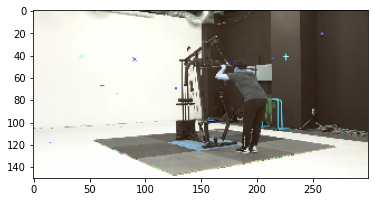

In [ ]:
plt.imshow(np.array(img).transpose(1,2,0))

In [ ]:
image , target = dataset.__getitem__(0)

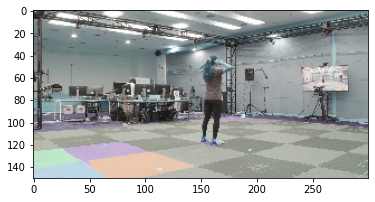

In [ ]:
# 데이터셋 확인해보기
plt.imshow(np.array(image).transpose(1,2,0))

In [ ]:
def get_model() -> nn.Module:
    backbone = resnet_fpn_backbone('resnet101', pretrained=True)
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,
        sampling_ratio=2
    )

    keypoint_roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=14,
        sampling_ratio=2
    )

    model = KeypointRCNN(
        backbone, 
        num_classes=2,
        num_keypoints=24,
        box_roi_pool=roi_pooler,
        keypoint_roi_pool=keypoint_roi_pooler
    )

    return model

In [ ]:
# loss and optim
model = get_model()
model.cuda()
criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(),lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-4)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
for epoch in range(num_epochs):
    model.train()
    for i, (images, targets) in enumerate(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        #loss = torch.sqrt(criterion(images, targets))
        losses = model(images, targets)

        loss = sum(loss for loss in losses.values())
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f'| epoch: {epoch} | loss: {loss.item():.4f}', end=' | ')
            for k, v in losses.items():
                print(f'{k[5:]}: {v.item():.4f}', end=' | ')
            print()

In [ ]:
model.eval()
pred = model(inputs.to(device))

In [ ]:
a = [x['keypoints'][0][:,:2].reshape(-1).detach().cpu().numpy() for x in pred ]
a[0]

array([160.66547 ,  54.27633 , 195.93826 ,  64.15483 , 173.92085 ,
        43.7243  , 171.67418 ,  70.21664 , 178.4142  ,  62.358738,
       180.66087 ,  64.37934 , 173.69618 ,  72.012726, 189.4229  ,
        68.19603 , 191.44492 ,  58.31754 , 173.92085 ,  54.27633 ,
       191.66957 ,  56.296932, 204.92494 ,  76.50295 , 164.93416 ,
        52.25573 , 169.65218 ,  25.987907, 167.4055  ,  72.237236,
       184.92955 ,  44.17332 , 187.17624 ,  64.37934 , 182.90755 ,
        58.31754 , 195.93826 ,  70.21664 , 165.15883 ,  54.27633 ,
       187.17624 ,  68.19603 , 193.91624 ,  60.33814 , 175.94286 ,
        66.17543 , 160.66547 ,  58.31754 ], dtype=float32)

In [ ]:
 pred[0]['keypoints']

In [ ]:
key = pred[0]['keypoints'][0][:,:2]
key = pred[1]['keypoints'][0][:,:2]
key = pred[2]['keypoints'][0][:,:2]
key.reshape(-1).detach().cpu().numpy()

array([160.66547 ,  54.27633 , 195.93826 ,  64.15483 , 173.92085 ,
        43.7243  , 171.67418 ,  70.21664 , 178.4142  ,  62.358738,
       180.66087 ,  64.37934 , 173.69618 ,  72.012726, 189.4229  ,
        68.19603 , 191.44492 ,  58.31754 , 173.92085 ,  54.27633 ,
       191.66957 ,  56.296932, 204.92494 ,  76.50295 , 164.93416 ,
        52.25573 , 169.65218 ,  25.987907, 167.4055  ,  72.237236,
       184.92955 ,  44.17332 , 187.17624 ,  64.37934 , 182.90755 ,
        58.31754 , 195.93826 ,  70.21664 , 165.15883 ,  54.27633 ,
       187.17624 ,  68.19603 , 193.91624 ,  60.33814 , 175.94286 ,
        66.17543 , 160.66547 ,  58.31754 ], dtype=float32)

In [ ]:
#추론
model.eval()
all_predictions = []
files = []
with torch.no_grad():
    for filenames, inputs in test_loader:
        pred = model(inputs.to(device))
        predictions = [x['keypoints'][0][:,:2].reshape(-1).detach().cpu().numpy() for x in pred ]
        files.extend(filenames)
        for prediction in predictions:
            all_predictions.append(prediction)

In [ ]:
all_predictions = np.array(all_predictions)
for i in range(all_predictions.shape[0]):
    all_predictions[i, [2*j for j in range(48//2)]] /= 300 / 1920
    all_predictions[i, [2*j + 1 for j in range(48//2)]] /= 150 / 1080

In [ ]:
df_sub = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv')
df = pd.DataFrame(columns=df_sub.columns)
df['image'] = files
df.iloc[:, 1:] = all_predictions
df.head()

SyntaxError: ignored

In [ ]:
df.to_csv('sub.csv', index=False)

In [ ]:
for filenames, inputs in test_loader:
  print(inputs)

TypeError: ignored

In [ ]:
for a,b in train_loader:
  print(a)

(tensor([[[0.9961, 0.9961, 0.9961,  ..., 0.9686, 0.9686, 0.9686],
         [0.9961, 0.9961, 0.9961,  ..., 0.9725, 0.9686, 0.9725],
         [0.9961, 0.9961, 0.9961,  ..., 0.9804, 0.9765, 0.9725],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.7098, 0.4118, 0.4902],
         [0.9961, 0.9961, 0.9961,  ..., 0.3922, 0.4824, 0.4824],
         [0.9961, 0.9961, 0.9961,  ..., 0.5137, 0.5255, 0.5294]],

        [[0.9961, 0.9961, 0.9961,  ..., 0.9647, 0.9647, 0.9647],
         [0.9961, 0.9961, 0.9961,  ..., 0.9686, 0.9647, 0.9686],
         [0.9961, 0.9961, 0.9961,  ..., 0.9725, 0.9725, 0.9686],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.6784, 0.4118, 0.5098],
         [0.9961, 0.9961, 0.9961,  ..., 0.4157, 0.4863, 0.4902],
         [0.9961, 0.9961, 0.9961,  ..., 0.5255, 0.5294, 0.5412]],

        [[0.9961, 0.9961, 0.9961,  ..., 0.9255, 0.9255, 0.9255],
         [0.9961, 0.9961, 0.9961,  ..., 0.9294, 0.9255, 0.9294],
         [0.9961, 0.9961, 0.9961,  ..., 0.9333, 0.9333, 0

KeyboardInterrupt: ignored

In [ ]:
inputs.shape

torch.Size([4, 3, 150, 300])